## Introduction

This project is using Major League Baseball (MLB) Statcast data from July of the 2019 baseball season. The scope of this project is to focus on pitch-level data in an effort to better predict what type of pitch a batter should expect. This project will be complete when we can determine associated features with pitch type, if any, allowing for implementation of batting strategies based on previous pitches and current game conditions. One challenge with discovering meaningful features is to arrange the data in such a way that makes sense for predicting pitches. Each observation in the data is currently captured as a single pitch, without reference to prior or future pitches in the at-bat. Successful prediction of a pitch will require creative manipulation of data so that all pitches in an at-bat can be referenced. This should be possible with the records of game id, pitch count, and batter.

## Imports and Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
data = pd.read_csv('data_cleaned.csv', index_col='index')

In [101]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
index,,,,,,,,,,,,,,,,,,,,,
1778,SI,2019-07-31,101.0,0.56,6.14,606466.0,547973.0,force_out,hit_into_play,6.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1839,SL,2019-07-31,88.1,0.55,6.24,606466.0,547973.0,NaN,foul,5.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1867,SL,2019-07-31,85.8,0.39,6.13,606466.0,547973.0,NaN,swinging_strike,13.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1932,FF,2019-07-31,96.5,0.72,6.13,572233.0,547973.0,walk,ball,12.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1956,FF,2019-07-31,96.8,0.50,6.16,572233.0,547973.0,NaN,ball,12.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110615 entries, 1778 to 22574
Data columns (total 62 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   pitch_type             110314 non-null  object 
 1   game_date              110615 non-null  object 
 2   release_speed          110327 non-null  float64
 3   release_pos_x          110323 non-null  float64
 4   release_pos_z          110323 non-null  float64
 5   batter                 110615 non-null  float64
 6   pitcher                110615 non-null  float64
 7   events                 28216 non-null   object 
 8   description            110615 non-null  object 
 9   zone                   110323 non-null  float64
 10  stand                  110615 non-null  object 
 11  p_throws               110615 non-null  object 
 12  type                   110615 non-null  object 
 13  hit_location           24620 non-null   float64
 14  bb_type                19165 non-n

## Data Exploration

### Target Feature: pitch_type

We start by diving into our target feature, 'pitch_type'. Pitch type is defined as the type of pitch derived from Statcast. It is possible that the Statcast system occasionally misclassifies a pitch type but we may not have a way to determine if and when this happens. The statcast pitch type abbreviations are associated with the following pitch types:

Changeup (CH),
Curveball (CU),
Cutter (FC),
Eephus (EP),
Forkball (FO),
Four-Seam Fastball (FF),
Knuckleball (KN),
Knuckle-curve (KC),
Screwball (SC),
Sinker (SI),
Slider (SL),
Splitter (FS),
Two-Seam Fastball (FT)

In [5]:
data['pitch_type'].unique()

array(['SI', 'SL', 'FF', 'CH', 'FS', 'FC', 'FT', 'EP', 'CU', 'KC', nan,
       'FO', 'KN'], dtype=object)

In [124]:
data['pitch_name'].unique()

array(['Sinker', 'Slider', '4-Seam Fastball', 'Changeup', 'Split-Finger',
       'Cutter', '2-Seam Fastball', 'Eephus', 'Curveball',
       'Knuckle Curve', nan, 'Forkball', 'Knuckleball'], dtype=object)

Every pitch type except SC (screwball) is represented in the data. This is not surprising given the difficulty of throwing this pitch. In fact, New York Daily News reports no one has thrown a SC in 2019 as of 7/21/19. Our data is from July 2019.

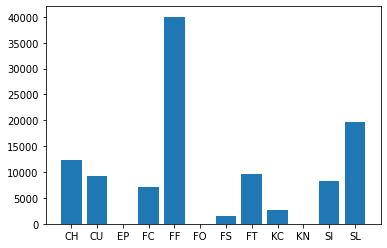

In [7]:
grouped = data.groupby('pitch_type', as_index = False)['index'].agg('count')
plt.bar(grouped['pitch_type'], grouped['index']);

FF is the most frequent pitch type with 36.3% of all pitches. SL and CH are the only other types with more than 10% at 17.8% and 11.2% respectively. 

In [18]:
pitch_counts = pd.concat([100 * data['pitch_type'].value_counts(normalize=True).round(3), data['pitch_type'].value_counts()], axis=1)
pitch_counts.columns = ['%', 'count']
pitch_counts

,%,count
FF,36.3,40020
SL,17.8,19666
CH,11.2,12350
FT,8.7,9638
CU,8.3,9160
SI,7.4,8181
FC,6.5,7153
KC,2.3,2586
FS,1.3,1480
KN,0.0,50


KN, FO, and EP have exceptionally low counts. This is expected as these 3 types of pitches are very difficult to throw and are rarely seen in MLB. Let's take a look at the pitchers that are capable of these pitches.

In [68]:
data.loc[data['pitch_type'] == 'KN', 'pitcher'].unique()

array([453214.])

In [69]:
data.loc[data['pitch_type'] == 'FO', 'pitcher'].unique()

array([571539.])

In [70]:
data.loc[data['pitch_type'] == 'EP', 'pitcher'].unique()

array([425844., 506433.])

One pitcher is responsible for each of the two types KN and FO. Somewhat unexpectedly given a count of 5, the EP pitch type was thrown by 2 different pitchers. The EP (eephus) is an extremely slow pitch that is usually thrown in jest or as an attempt to aggitate your opponent.

## Speed vs. Pitch Type

One of two major benefits, and arguably the most valuable, in predicting pitch type is the knowledge of pitch speed. The other is ball movement and both are associated with pitch type. The data has reference to 2 speeds: release_speed and effective_speed. The release speed is measured by Statcast as the ball leaves the pitcher's hand, and the effective speed is a derived speed based on the extension of the pitcher's release.

In [78]:
data[['release_speed', 'effective_speed']].describe()

,release_speed,effective_speed
count,110327.000000,110612.000000
mean,88.742331,88.233588
std,5.966305,7.743009
min,50.800000,0.000000
25%,84.500000,84.000000
50%,90.000000,89.700000
75%,93.500000,93.500000
max,102.300000,103.500000


In [83]:
len(data['effective_speed'][data['effective_speed'] == 0])

289

A minimum speed of 0.0 doesn't make sense. Effective speed stats are skewed by 289 zero values so we'll filter for speeds greater than 0.

In [84]:
data.loc[data['effective_speed'] > 0, 'effective_speed'].describe()

count    110323.000000
mean         88.464723
std           6.297918
min          48.500000
25%          84.000000
50%          89.700000
75%          93.500000
max         103.500000
Name: effective_speed, dtype: float64

We can see the release speed and effective speed are very close. Given the definitions of the two speeds, we'll focus on release_speed moving forward.

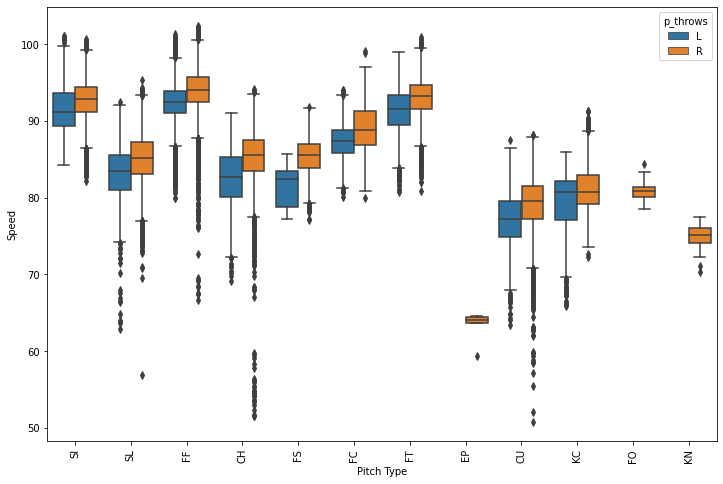

In [85]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='pitch_type', y='release_speed', hue='p_throws', data=data)
plt.xticks(rotation='vertical')
plt.ylabel('Speed')
plt.xlabel('Pitch Type');

Here we can see how speed varies by pitch type. A batter's swing timing will depend on the speed of the pitch. The box plot above shows how a FF is much faster than a SL or CH. Note that right handed pitchers tend to throw faster pitches for all pitch types. They also have a larger range, especially on the slow end, than left handed pitchers. The range is most likely due to the higher count of right handers.

### Summary of Feature Columns

In [108]:
data.iloc[:,0:17].describe()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,hit_location,balls,strikes
count,110327.000000,110323.000000,110323.00000,110615.000000,110615.000000,110323.000000,24620.000000,110615.000000,110615.000000
mean,88.742331,-0.726779,5.89709,573018.066998,572594.659793,9.219320,5.076036,0.882602,0.901894
std,5.966305,1.948320,0.49793,67183.160782,67262.753649,4.186222,2.640747,0.968063,0.828099
min,50.800000,-5.380000,0.59000,405395.000000,282332.000000,1.000000,1.000000,0.000000,0.000000
25%,84.500000,-2.130000,5.63000,519390.000000,519443.000000,6.000000,2.000000,0.000000,0.000000
50%,90.000000,-1.490000,5.92000,592680.000000,592858.000000,11.000000,5.000000,1.000000,1.000000
75%,93.500000,1.290000,6.23000,623993.000000,621366.000000,13.000000,8.000000,2.000000,2.000000
max,102.300000,4.650000,7.35000,670970.000000,673633.000000,14.000000,9.000000,3.000000,2.000000


In [111]:
data.iloc[:,17:27].describe()

,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning
count,110323.000000,110323.000000,110323.000000,110323.000000,9956.000000,20231.000000,33138.000000,110615.000000,110615.000000
mean,-0.132685,0.641114,0.040273,2.261314,574378.089594,572664.722604,572786.314503,0.978782,5.052850
std,0.852389,0.720861,0.852031,0.958757,67103.807323,67861.184641,66666.014229,0.817827,2.707358
min,-2.150000,-1.990000,-4.230000,-3.030000,405395.000000,405395.000000,405395.000000,0.000000,1.000000
25%,-0.850000,0.220000,-0.540000,1.640000,519299.000000,519222.000000,519222.000000,0.000000,3.000000
50%,-0.220000,0.770000,0.040000,2.260000,592885.000000,592743.000000,592663.000000,1.000000,5.000000
75%,0.530000,1.220000,0.620000,2.880000,624424.000000,623993.000000,623993.000000,2.000000,7.000000
max,2.340000,2.370000,5.180000,7.080000,670712.000000,670712.000000,670712.000000,2.000000,16.000000


In [117]:
data.iloc[:,27:36].describe()

,hc_x,hc_y,fielder_2,vx0,vy0,vz0,ax,ay,az
count,19131.000000,19131.000000,110615.000000,110323.000000,110323.000000,110323.000000,110323.000000,110323.000000,110323.000000
mean,126.635914,119.704841,545935.081842,2.218278,-129.038358,-4.180477,-2.352650,25.217753,-23.601090
std,41.406239,44.641579,66114.784146,5.978135,8.667007,2.974875,10.246112,3.658441,8.549595
min,2.710000,3.950000,425772.000000,-19.313778,-148.902158,-19.919902,-27.699840,8.675211,-49.534956
25%,102.200000,84.160000,488771.000000,-2.750863,-135.942034,-6.192820,-11.019936,22.457481,-29.523731
50%,126.050000,121.220000,547172.000000,4.041285,-130.792465,-4.313729,-2.568948,25.234514,-22.871113
75%,154.130000,156.690000,595978.000000,6.598750,-122.865623,-2.313197,5.378733,27.934175,-16.375780
max,246.460000,224.860000,669257.000000,18.453851,-73.186873,13.810555,27.338943,38.162205,-4.112185


In [119]:
data.iloc[:,36:45].describe()

,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk
count,110323.000000,110323.000000,29607.000000,30921.000000,30921.000000,110612.000000,108285.000000,110323.000000,110615.000000
mean,3.369567,1.608323,165.936265,84.058814,16.584813,88.233588,2247.545265,5.997856,566202.750893
std,0.190277,0.113042,124.244483,14.048170,28.667460,7.743009,322.105041,0.495090,834.508178
min,2.510000,0.760000,0.000000,15.500000,-88.000000,0.000000,454.000000,0.600000,564777.000000
25%,3.250000,1.540000,29.000000,74.100000,-3.000000,84.000000,2099.000000,5.700000,565463.000000
50%,3.370000,1.600000,174.000000,83.300000,18.000000,89.700000,2268.000000,6.000000,566218.000000
75%,3.490000,1.670000,262.000000,95.400000,37.000000,93.500000,2433.000000,6.300000,566913.000000
max,4.280000,2.230000,500.000000,117.300000,89.000000,103.500000,3741.000000,8.000000,567608.000000


In [120]:
data.iloc[:,45:55].describe()

,pitcher.1,fielder_2.1,release_pos_y,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score
count,110615.000000,110615.000000,110323.000000,18969.000000,110615.000000,110615.000000,110615.000000,110615.000000,110615.000000
mean,572594.659793,545935.081842,54.502110,3.194950,39.697889,2.924287,2.347331,2.606066,2.455137
std,67262.753649,66114.784146,0.494228,1.243691,23.584122,1.747854,2.642376,3.023269,2.799892
min,282332.000000,425772.000000,52.460000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,519443.000000,488771.000000,54.170000,2.000000,19.000000,1.000000,0.000000,0.000000,0.000000
50%,592858.000000,547172.000000,54.490000,3.000000,39.000000,3.000000,2.000000,2.000000,2.000000
75%,621366.000000,595978.000000,54.830000,4.000000,59.000000,4.000000,4.000000,4.000000,4.000000
max,673633.000000,669257.000000,59.940000,6.000000,139.000000,13.000000,19.000000,19.000000,19.000000


In [123]:
data.iloc[:,55:61].describe()

,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score
count,110615.000000,110615.000000,110615.000000,110615.000000,110615.000000
mean,2.498260,2.622773,2.363314,2.487827,2.498260
std,2.883653,3.029959,2.648888,2.813434,2.883653
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000
max,19.000000,19.000000,19.000000,19.000000,19.000000


In [134]:
data['events'].value_counts()

field_out                       10907
strikeout                        6522
single                           3999
walk                             2183
double                           1363
home_run                         1057
force_out                         528
grounded_into_double_play         525
hit_by_pitch                      281
field_error                       214
sac_fly                           172
triple                            121
sac_bunt                          104
double_play                        67
fielders_choice                    64
fielders_choice_out                41
strikeout_double_play              24
caught_stealing_2b                 21
catcher_interf                      8
batter_interference                 8
triple_play                         1
pickoff_caught_stealing_home        1
pickoff_3b                          1
pickoff_2b                          1
pickoff_1b                          1
caught_stealing_3b                  1
other_out   

In [135]:
data['description'].value_counts()

ball                       36706
foul                       20130
hit_into_play              19166
called_strike              17882
swinging_strike            11708
blocked_ball                2573
foul_tip                     967
swinging_strike_blocked      895
hit_by_pitch                 281
foul_bunt                    256
missed_bunt                   37
pitchout                      11
bunt_foul_tip                  3
Name: description, dtype: int64

In [137]:
data['stand'].value_counts()

R    64362
L    46253
Name: stand, dtype: int64

In [138]:
data['p_throws'].value_counts()

R    79787
L    30828
Name: p_throws, dtype: int64

In [139]:
data['type'].value_counts()

S    51879
B    39570
X    19166
Name: type, dtype: int64

How many at-bats are there per game?

In [5]:
data.groupby('game_pk')['at_bat_number'].agg(max).mean()

77.42896174863388

 How many pitches per at-bat?

In [6]:
data.groupby(['game_pk', 'at_bat_number'])['pitch_number'].agg(max).mean()

3.9148823217129713

## Data Transformation

In [148]:
basics = data[['game_pk', 'at_bat_number', 'pitch_number', 'pitch_type', 'balls', 'strikes']]
basics.head()

,game_pk,at_bat_number,pitch_number,pitch_type,balls,strikes
index,,,,,,
1778,567514.0,77.0,3.0,SI,0.0,2.0
1839,567514.0,77.0,2.0,SL,0.0,1.0
1867,567514.0,77.0,1.0,SL,0.0,0.0
1932,567514.0,76.0,4.0,FF,3.0,0.0
1956,567514.0,76.0,3.0,FF,2.0,0.0
